In [1]:
import sys
import os
project_dir = os.path.abspath("/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation")
#---------- Define paths for the specific subfolders
data_scripts_path = os.path.join(project_dir, "data_processing")
model_scripts_path = os.path.join(project_dir, "model")
#---------- Append the subfolder paths to sys.path
sys.path.append(data_scripts_path)
sys.path.append(model_scripts_path)

In [2]:
from packages import*

2025-04-10 07:45:10.651994: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 07:45:10.716243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 07:45:11.886764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from data_loader import x_input, y_input
# from global_mean import  global_mean
from spatial_ednn_model import evidential_regression_model
from regridder import regrid_to_lat_lon
from euclidean_distance import EucDistance
from fast_model import fast_model

## Load Data

In [4]:
#---------- Compute CLM PPE season
clm_ppe_path ="/bsuhome/ksilwimba/scratch/NCAR/Data/LAI/TLAI"
djf_seas_tr, mam_seas_tr, jja_seas_tr, son_seas_tr = y_input(clm_ppe_path, start_year=1901, end_year=2000)
djf_seas_va, mam_seas_va, jja_seas_va, son_seas_va = y_input(clm_ppe_path, start_year=2000, end_year=2014)

In [5]:
conus_gridcells = list(range(50, 150))
djf_conus = djf_seas_tr.sel(gridcell=conus_gridcells)

In [6]:
djf_conus.TLAI[:,1:200]

<xarray.DataArray 'TLAI' (gridcell: 100, sample: 199)>
dask.array<getitem, shape=(100, 199), dtype=float32, chunksize=(100, 199), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object MultiIndex
  * member   (sample) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * time     (sample) object 1901-02-01 00:00:00 ... 1967-02-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

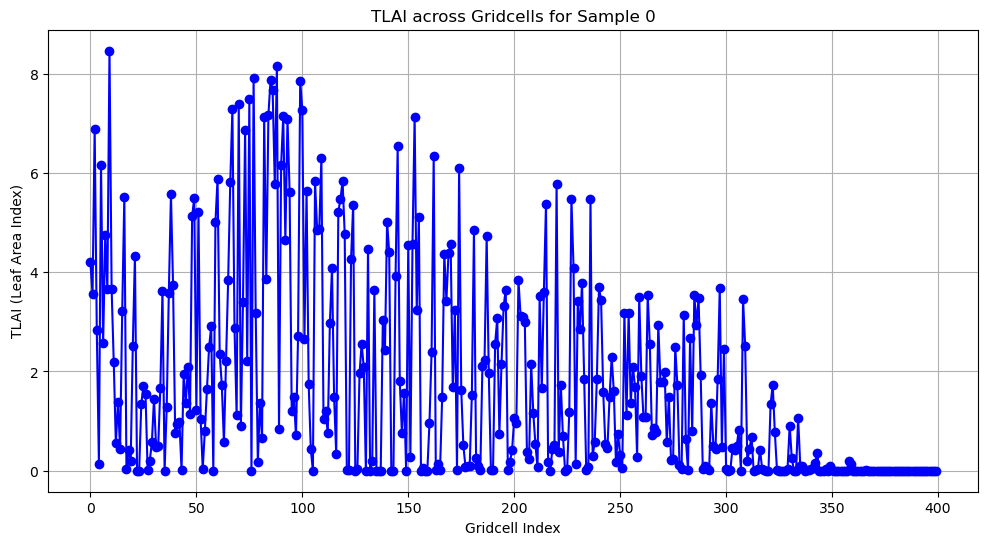

In [7]:
sample_index = 0
tlai_data = djf_seas_tr['TLAI'].isel(sample=sample_index)

# Plot TLAI values across grid cells
plt.figure(figsize=(12, 6))
plt.plot(tlai_data.gridcell, tlai_data, marker='o', linestyle='-', color='b')
plt.xlabel("Gridcell Index")
plt.ylabel("TLAI (Leaf Area Index)")
plt.title(f"TLAI across Gridcells for Sample {sample_index}")
plt.grid(True)
plt.show()


In [8]:
djf_seas_tr#.gridcell

<xarray.Dataset>
Dimensions:  (gridcell: 400, sample: 150000)
Coordinates:
  * sample   (sample) object MultiIndex
  * member   (sample) int64 1 1 1 1 1 1 1 1 ... 500 500 500 500 500 500 500 500
  * time     (sample) object 1901-01-01 00:00:00 ... 2000-12-01 00:00:00
Dimensions without coordinates: gridcell
Data variables:
    TLAI     (gridcell, sample) float32 dask.array<chunksize=(400, 1500), meta=np.ndarray>

In [9]:
djf_seas_tr.gridcell

<xarray.DataArray 'gridcell' (gridcell: 400)>
array([  0,   1,   2, ..., 397, 398, 399])
Dimensions without coordinates: gridcell

In [10]:
param_file_path = "/bsuhome/ksilwimba/scratch/NCAR/Data/helpers/lhc220926.txt"

#---------- Create x-train input
x_djf_tr, x_djf_tr_no_cyclic = x_input(djf_seas_tr, param_file_path)
x_mam_tr, x_mam_tr_no_cyclic = x_input(mam_seas_tr, param_file_path)
x_jja_tr, x_jja_tr_no_cyclic = x_input(jja_seas_tr, param_file_path)
x_son_tr, x_son_tr_no_cyclic = x_input(son_seas_tr, param_file_path)

#---------- Create x-train input
x_djf_va, x_djf_va_no_cyclic = x_input(djf_seas_va, param_file_path)
x_mam_va, x_mam_va_no_cyclic = x_input(mam_seas_va, param_file_path)
x_jja_va, x_jja_va_no_cyclic = x_input(jja_seas_va, param_file_path)
x_son_va, x_son_va_no_cyclic = x_input(son_seas_va, param_file_path)

In [11]:
djf_seas_tr

<xarray.Dataset>
Dimensions:  (gridcell: 400, sample: 150000)
Coordinates:
  * sample   (sample) object MultiIndex
  * member   (sample) int64 1 1 1 1 1 1 1 1 ... 500 500 500 500 500 500 500 500
  * time     (sample) object 1901-01-01 00:00:00 ... 2000-12-01 00:00:00
Dimensions without coordinates: gridcell
Data variables:
    TLAI     (gridcell, sample) float32 dask.array<chunksize=(400, 1500), meta=np.ndarray>

## Scale Data

#### Quantile Transformer 

In [12]:
#----------- Scaled x train and validation
scaler_x = QuantileTransformer(output_distribution='normal')
x_djf_tr_scaled = scaler_x.fit_transform(x_djf_tr)
x_mam_tr_scaled = scaler_x.fit_transform(x_mam_tr)
x_jja_tr_scaled = scaler_x.fit_transform(x_jja_tr)
x_son_tr_scaled = scaler_x.fit_transform(x_son_tr)

x_djf_va_scaled = scaler_x.transform(x_djf_va)
x_mam_va_scaled = scaler_x.transform(x_mam_va)
x_jja_va_scaled = scaler_x.transform(x_jja_va)
x_son_va_scaled = scaler_x.transform(x_son_va) 

In [13]:
#----------- Scaled x train and validation no cyclical encoding
scaler_x_no_cyclic = QuantileTransformer(output_distribution='normal')
x_djf_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_djf_tr_no_cyclic)
x_mam_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_mam_tr_no_cyclic)
x_jja_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_jja_tr_no_cyclic)
x_son_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_son_tr_no_cyclic)

x_djf_va_scaled_ = scaler_x_no_cyclic.transform(x_djf_va_no_cyclic)
x_mam_va_scaled_ = scaler_x_no_cyclic.transform(x_mam_va_no_cyclic)
x_jja_va_scaled_ = scaler_x_no_cyclic.transform(x_jja_va_no_cyclic)
x_son_va_scaled_ = scaler_x_no_cyclic.transform(x_son_va_no_cyclic) 

In [14]:
# #----------- Scaled x train and validation
# scaler_x = StandardScaler()
# x_djf_tr_scaled = scaler_x.fit_transform(x_djf_tr)
# x_mam_tr_scaled = scaler_x.fit_transform(x_mam_tr)
# x_jja_tr_scaled = scaler_x.fit_transform(x_jja_tr)
# x_son_tr_scaled = scaler_x.fit_transform(x_son_tr)


# x_djf_va_scaled = scaler_x.transform(x_djf_va)
# x_mam_va_scaled = scaler_x.transform(x_mam_va)
# x_jja_va_scaled = scaler_x.transform(x_jja_va)
# x_son_va_scaled = scaler_x.transform(x_son_va) 

In [15]:
# #----------- Scaled x train and validation no cyclical encoding
# scaler_x_no_cyclic = StandardScaler()
# x_djf_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_djf_tr_no_cyclic)
# x_mam_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_mam_tr_no_cyclic)
# x_jja_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_jja_tr_no_cyclic)
# x_son_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_son_tr_no_cyclic)


# x_djf_va_scaled_ = scaler_x_no_cyclic.transform(x_djf_va_no_cyclic)
# x_mam_va_scaled_ = scaler_x_no_cyclic.transform(x_mam_va_no_cyclic)
# x_jja_va_scaled_ = scaler_x_no_cyclic.transform(x_jja_va_no_cyclic)
# x_son_va_scaled_ = scaler_x_no_cyclic.transform(x_son_va_no_cyclic) 

In [16]:
# EvidentialRegressorDNN??

## EDNN Model 

In [17]:
n_features = 35
n_output_tasks = 400

model_folder = "/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model"
model_path =  model_folder+"/sparse_djf_ednn_model.keras"

p_with_unc_djf, p_without_unc_djf, model_ednn_djf, history_djf = evidential_regression_model(
    x_djf_tr_scaled,
    djf_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.9756
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1162
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.2932
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.3562
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.3902
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.4452
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.5111
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.5771
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.6083
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.6414
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_djf_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/sav

In [18]:
model_path = model_folder+"/sparse_mam_ednn_model.keras"
p_with_unc_mam, p_without_unc_mam, model_ednn_mam, history_mam = evidential_regression_model(
    x_mam_tr_scaled,
    mam_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.7939
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.2908
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.4296
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.5340
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.6203
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.6921
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.7516
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: -0.7942
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.8284
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.8678
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_mam_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/sav

In [19]:
model_path = model_folder+"/sparse_jja_ednn_model.keras"
p_with_unc_jja, p_without_unc_jja, model_ednn_jja, history_jja = evidential_regression_model(
    x_jja_tr_scaled,
    jja_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2825
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3141
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1234
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0653
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0279
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0226
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0918
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1379
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1636
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1907
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_jja_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_m

In [20]:
model_path = model_folder+"/sparse_son_ednn_model.keras"
p_with_unc_son, p_without_unc_son, model_ednn_son, history_son = evidential_regression_model(
    x_son_tr_scaled,
    son_seas_tr.TLAI.T.values,
    model_path,
    hidden_layers=6,
    batch_size=500,
    n_output_tasks=n_output_tasks,
    epochs=10,
    loss_weight=0.01
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.2459
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1835
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0353
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0383
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0985
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1492
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1857
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.2255
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.2374
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.2606
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model successfully saved to: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved_model/sparse_son_ednn_model.keras
Model successfully loaded from: /bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/spatial_ppe_emulation/saved

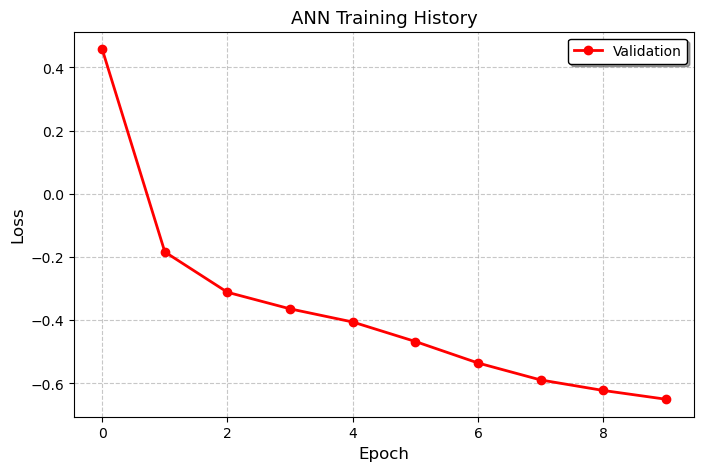

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(history_djf.epoch, history_djf.history['loss'], label='Validation', marker='o', linestyle='-', linewidth=2, color='red')
# plt.plot(history_djf.epoch, history_djf.history['mse'], label='Train', marker='o', linestyle='--', linewidth=2, color='blue')
plt.legend(shadow = True, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoch', fontsize=12)
plt.title('ANN Training History', fontsize=13)
plt.savefig("./Figures/TSgrid_mse_anom.pdf", bbox_inches='tight')
plt.show()

In [22]:
sparse_pred_ednn_djf = model_ednn_djf.predict(x_djf_va_scaled)
sparse_pred_ednn_mam = model_ednn_mam.predict(x_mam_va_scaled)
sparse_pred_ednn_jja = model_ednn_jja.predict(x_jja_va_scaled)
sparse_pred_ednn_son = model_ednn_son.predict(x_son_va_scaled)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [23]:
#----------- Pred LAI
pred_djf_lai = sparse_pred_ednn_djf[:,:400]
pred_mam_lai = sparse_pred_ednn_mam[:,:400]
pred_jja_lai = sparse_pred_ednn_jja[:,:400]
pred_son_lai = sparse_pred_ednn_son[:,:400]

#---------- Aleatoric 
pred_djf_alea = sparse_pred_ednn_djf[:,400:800] 
pred_mam_alea = sparse_pred_ednn_mam[:,400:800] 
pred_jja_alea = sparse_pred_ednn_jja[:,400:800] 
pred_son_alea = sparse_pred_ednn_son[:,400:800] 

#---------- Epistemic 
pred_djf_epis = sparse_pred_ednn_djf[:,800:] 
pred_mam_epis = sparse_pred_ednn_mam[:,800:] 
pred_jja_epis = sparse_pred_ednn_jja[:,800:] 
pred_son_epis = sparse_pred_ednn_son[:,800:] 

In [24]:
pred_djf_lai

array([[ 5.0644836e+00,  4.0398889e+00,  1.0038359e+01, ...,
         1.1578400e-02,  9.5662121e-03,  1.0700656e-02],
       [ 4.5148749e+00,  3.7068975e+00,  8.5320425e+00, ...,
         7.5848079e-03,  1.5904924e-03,  6.1925864e-03],
       [ 5.0644836e+00,  4.0398889e+00,  1.0038359e+01, ...,
         1.1578400e-02,  9.5662121e-03,  1.0700656e-02],
       ...,
       [ 4.4728847e+00,  3.4905083e+00,  9.2965479e+00, ...,
         1.9140211e-03, -3.4481697e-03,  7.6289726e-03],
       [ 4.5183125e+00,  3.7731452e+00,  8.2000217e+00, ...,
         1.3328865e-03, -2.9959464e-03,  5.8981013e-03],
       [ 4.4728847e+00,  3.4905083e+00,  9.2965479e+00, ...,
         1.9140211e-03, -3.4481697e-03,  7.6289726e-03]], dtype=float32)

In [25]:
########### Sparse Prediction
sparse_pred_ednn_djf = model_ednn_djf.predict(x_djf_va_scaled)
sparse_pred_ednn_mam = model_ednn_mam.predict(x_mam_va_scaled)
sparse_pred_ednn_jja = model_ednn_jja.predict(x_jja_va_scaled)
sparse_pred_ednn_son = model_ednn_son.predict(x_son_va_scaled)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [26]:
#------------------- Select CONUS region
us_lat_bounds = (25.031414,50)#(24.031414,49.47644)
us_lon_bounds = (233.75,293.75)

In [27]:
#################### EDNN Covert and Regrid 
#---------- list of seasons
seasons = ['djf', 'mam', 'jja', 'son']
#---------- Map season names to their corresponding variables
seas_va = {
    'djf': djf_seas_va,
    'mam': mam_seas_va,
    'jja': jja_seas_va,
    'son': son_seas_va
}

pred_lai = {
    'djf': pred_djf_lai,
    'mam': pred_mam_lai,
    'jja': pred_jja_lai,
    'son': pred_son_lai
}

#---------- Initialize dictionaries to store the results
sparse_pred_ednn = {}
pred_ednn = {}

#----------  Loop over each season
for season in seasons:
    # Extract the coordinate data for the current season
    sample_coords = seas_va[season].sample.data
    member_coords = seas_va[season].member.data
    time_coords = seas_va[season].time.data

    #---------- Create the sparse prediction DataArray for the current season
    sparse_pred_ednn[season] = xr.DataArray(
        data=pred_lai[season],
        dims=['sample', 'gridcell'],
        coords=dict(
            sample=sample_coords,
            member=('sample', member_coords),
            time=('sample', time_coords)
        ),
        attrs={
            'long_name': 'total projected leaf area index',
            'units': '$m^2/m^2$',
            'cell_methods': 'time: mean'
        }
    )

    #---------- Regrid the sparse DataArray to standard latitude/longitude grid
    pred_ednn[season] = regrid_to_lat_lon(sparse_pred_ednn[season]).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
    
lat = pred_ednn['djf'].lat
lon = pred_ednn['djf'].lon

In [28]:
djf_seas_va_clm = regrid_to_lat_lon(djf_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
mam_seas_va_clm = regrid_to_lat_lon(mam_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
jja_seas_va_clm = regrid_to_lat_lon(jja_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))
son_seas_va_clm = regrid_to_lat_lon(son_seas_va.TLAI.T).sel(lat=slice(*us_lat_bounds),\
                                                                         lon=slice(*us_lon_bounds))

In [29]:
lat

<xarray.DataArray 'lat' (lat: 13)>
array([25.578947, 27.473684, 29.368422, 31.263159, 33.157894, 35.052631,
       36.947369, 38.842106, 40.736843, 42.63158 , 44.526318, 46.421051,
       48.315788])
Coordinates:
  * lat      (lat) float64 25.58 27.47 29.37 31.26 ... 42.63 44.53 46.42 48.32

In [30]:
sparse_pred_ednn_djf.shape

(22500, 1200)

In [31]:
#################### Epistemic Unvertainty Covert and Regrid 
#---------- list of seasons
seasons = ['djf', 'mam', 'jja', 'son']
#---------- Map season names to their corresponding variables
seas_va = {
    'djf': djf_seas_va,
    'mam': mam_seas_va,
    'jja': jja_seas_va,
    'son': son_seas_va
}

pred_alea = {
    'djf': pred_djf_alea,
    'mam': pred_mam_alea,
    'jja': pred_jja_alea,
    'son': pred_son_alea
}

#---------- Initialize dictionaries to store the results
sparse_pred_ednn_alea = {}
pred_ednn_alea = {}

#----------  Loop over each season
for season in seasons:
    # Extract the coordinate data for the current season
    sample_coords = seas_va[season].sample.data
    member_coords = seas_va[season].member.data
    time_coords = seas_va[season].time.data

    #---------- Create the sparse prediction DataArray for the current season
    sparse_pred_ednn_alea[season] = xr.DataArray(
        data=pred_alea[season],
        dims=['sample', 'gridcell'],
        coords=dict(
            sample=sample_coords,
            member=('sample', member_coords),
            time=('sample', time_coords)
        ),
        attrs={
            'long_name': 'Aleatoric Uncertainty',
            'units': '',
            'cell_methods': 'time: mean'
        }
    )

    #---------- Regrid the sparse DataArray to standard latitude/longitude grid
    pred_ednn_alea[season] = regrid_to_lat_lon(sparse_pred_ednn_alea[season]).sel(lat=slice(*us_lat_bounds),\
                                                                                   lon=slice(*us_lon_bounds))

In [32]:
#################### Epistemic Unvertainty Covert and Regrid 
#---------- list of seasons
seasons = ['djf', 'mam', 'jja', 'son']
#---------- Map season names to their corresponding variables
seas_va = {
    'djf': djf_seas_va,
    'mam': mam_seas_va,
    'jja': jja_seas_va,
    'son': son_seas_va
}

pred_epis = {
    'djf': pred_djf_epis,
    'mam': pred_mam_epis,
    'jja': pred_jja_epis,
    'son': pred_son_epis
}

#---------- Initialize dictionaries to store the results
sparse_pred_ednn_epis = {}
pred_ednn_epis = {}

#----------  Loop over each season
for season in seasons:
    # Extract the coordinate data for the current season
    sample_coords = seas_va[season].sample.data
    member_coords = seas_va[season].member.data
    time_coords = seas_va[season].time.data

    #---------- Create the sparse prediction DataArray for the current season
    sparse_pred_ednn_epis[season] = xr.DataArray(
        data=pred_epis[season],
        dims=['sample', 'gridcell'],
        coords=dict(
            sample=sample_coords,
            member=('sample', member_coords),
            time=('sample', time_coords)
        ),
        attrs={
            'long_name': 'Epistemic Uncertainty',
            'units': '',
            'cell_methods': 'time: mean'
        }
    )

    #---------- Regrid the sparse DataArray to standard latitude/longitude grid
    pred_ednn_epis[season] = regrid_to_lat_lon(sparse_pred_ednn_epis[season]).sel(lat=slice(*us_lat_bounds),\
                                                                                   lon=slice(*us_lon_bounds))

In [33]:
# =============================================================================
# 4. Euclidean Distance Function
# =============================================================================
#================EXP1
djf = EucDistance(djf_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['djf'][:, :].mean(dim="sample"))
mam = EucDistance(mam_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['mam'][:, :].mean(dim="sample"))
jja = EucDistance(jja_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['jja'][:, :].mean(dim="sample"))
son = EucDistance(son_seas_va_clm[:, :].mean(dim="sample"), pred_ednn['son'][:, :].mean(dim="sample"))

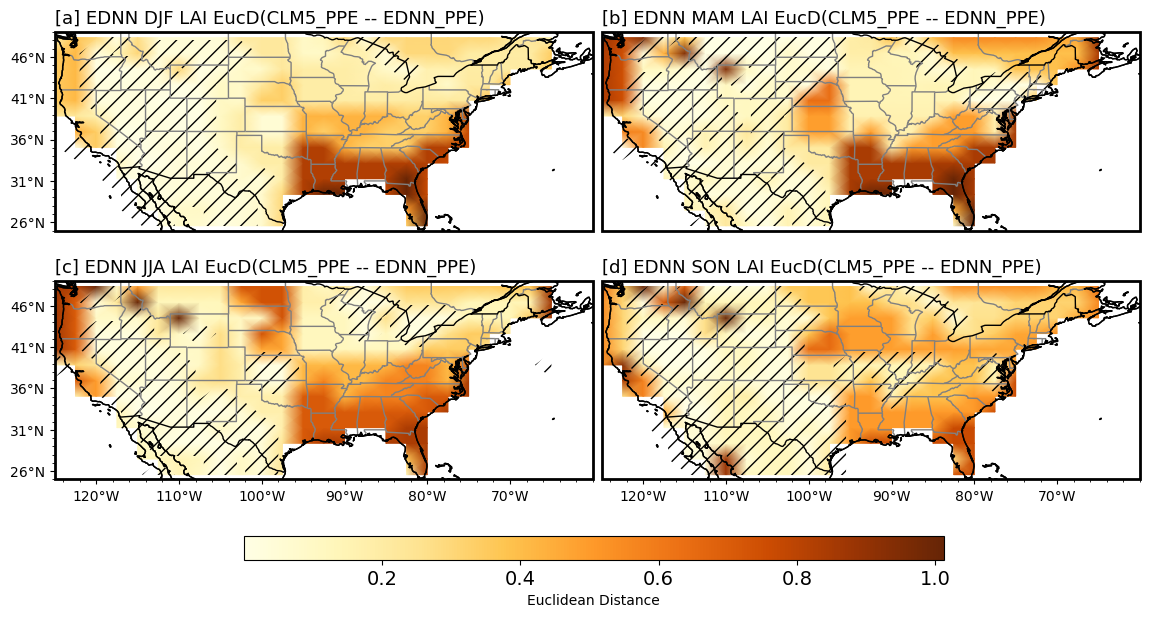

In [34]:
def make_plot_without_contours(
    data_nc: Any,
    ax: Axes,
    threshold: float,
    title: str,
    is_first_subplot: bool = False,
    is_last_row: bool = False
) -> QuadMesh:
    """
    Create a filled pcolormesh plot with a hatch overlay for regions below a threshold.

    Parameters
    ----------
    data_nc : Any
        Input data array (or similar object) containing at least 'lat' and 'lon' coordinates.
    ax : Axes
        The matplotlib GeoAxes on which to plot.
    threshold : float
        The threshold below which hatch patterns are applied.
    title : str
        The title for the subplot.
    is_first_subplot : bool, optional
        If True, sets the y-tick labels (default is False).
    is_last_row : bool, optional
        If True, sets the x-tick labels (default is False).

    Returns
    -------
    QuadMesh
        The QuadMesh object created by pcolormesh.
    """
    # --- Add a cyclic point to avoid a gap in the map
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']

    # --- Create a 2D meshgrid of longitudes and latitudes
    lons2d, lats2d = np.meshgrid(lons, lats)

    # --- Create a filled pcolormesh plot
    mesh = ax.pcolormesh(
        lons2d,
        lats2d,
        data,
        transform=ccrs.PlateCarree(),
        cmap='YlOrBr',
        shading='gouraud'
    )

    # --- Set the subplot title
    ax.set_title(title, fontweight='regular', fontsize=13, loc='left')

    # --- Create a hatch mask for areas below the threshold
    hatch_mask = np.ma.masked_less(data, threshold)
    ax.contourf(
        lons,
        lats,
        hatch_mask.mask,
        levels=[0.2, 3],
        colors='none',
        hatches=['//'],
        transform=ccrs.PlateCarree()
    )

    # --- Configure x-ticks for the bottom row of subplots
    if is_last_row:
        xticks = np.arange(-120, -60, 10)
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())

    # --- Configure y-ticks for the first column of subplots
    if is_first_subplot:
        yticks = np.arange(26, 50, 5)
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

    # --- Add state and country boundaries
    states = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')

    # --- Enable minor ticks and add coastlines
    ax.minorticks_on()
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)

    return mesh

# --- Main plotting routine
if __name__ == '__main__':
    # Create a 2x2 figure with Cartopy PlateCarree projection
    fig, ax = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=[14,8],
        subplot_kw={'projection': ccrs.PlateCarree()},
        gridspec_kw={'wspace': 0.017, 'hspace': -0.2}
    )

    # Set a border around each subplot for visual clarity
    common_extent = [-125, -60, 25, 49]
    for axis in ax.flat:
        axis.set_extent(common_extent, crs=ccrs.PlateCarree())
        axis.spines['geo'].set_edgecolor('black')
        axis.spines['geo'].set_linewidth(2)

    # Define the threshold for hatching
    threshold = 0.2

    # Create spatial maps for different seasons (replace djf, mam, jja, son with your data)
    mesh14a = make_plot_without_contours(
        djf, ax[0, 0], threshold,
        '[a] EDNN DJF LAI EucD(CLM5_PPE -- EDNN_PPE)',
        is_first_subplot=True
    )
    mesh14b = make_plot_without_contours(
        mam, ax[0, 1], threshold,
        '[b] EDNN MAM LAI EucD(CLM5_PPE -- EDNN_PPE)'
    )
    mesh14c = make_plot_without_contours(
        jja, ax[1, 0], threshold,
        '[c] EDNN JJA LAI EucD(CLM5_PPE -- EDNN_PPE)',
        is_first_subplot=True,
        is_last_row=True
    )
    mesh14d = make_plot_without_contours(
        son, ax[1, 1], threshold,
        '[d] EDNN SON LAI EucD(CLM5_PPE -- EDNN_PPE)',
        is_last_row=True
    )

    # --- Adjust layout and add a horizontal colorbar
    fig.subplots_adjust(bottom=0.2, top=0.9)
    cbar_ax = fig.add_axes([0.26, 0.17, 0.5, 0.03])
    cbar = fig.colorbar(mesh14d, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Euclidean Distance', fontweight='regular', fontsize=10)

    # --- Save and display the figure
    plt.savefig("./Figures/euclidean_dist.pdf", dpi=600, bbox_inches='tight')
    plt.show()


In [35]:
def _make_plot_without_contours_(data_nc, ax, title, is_first_subplot=False, is_last_row=False):
    #=================== Add cyclic point to data and longitude
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    #=================== Make a filled plot without contours using pcolormesh
    mesh = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='RdYlBu', shading='gouraud')
    
    # Set titles
    # ax.set_title(f"m$^2$/m$^2$", loc='right', fontweight='regular', size=10)
    ax.set_title(title, fontweight='regular', fontsize=13, loc='left')
    
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    if is_first_subplot:
        ax.set_yticks(np.arange(26, 49, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Add state boundaries
    states = cfeature.NaturalEarthFeature(category='cultural',
                                          name='admin_1_states_provinces_lines',
                                          scale='50m', facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    
    ax.minorticks_on()  # Enable minor ticks on both axes
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    # Create an inset axes using `ax.inset_axes`
    inset_ax = ax.inset_axes([.84, 0.13, 0.15, 0.29], transform=ax.transAxes)
    # Plot the distribution on the inset axes
    # Flatten the data and remove NaNs
    data_flat = data.flatten()
    data_flat = data_flat[~np.isnan(data_flat)]
    inset_ax.hist(
        data_flat, bins=30, color='g', edgecolor='black'
    )
    inset_ax.set_title('Distribution', fontsize=7)
    inset_ax.tick_params(axis='both', which='major', labelsize=7)
    inset_ax.set_ylabel('Density', fontsize=6)
    # Remove spines for a cleaner look
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)
    
    return mesh

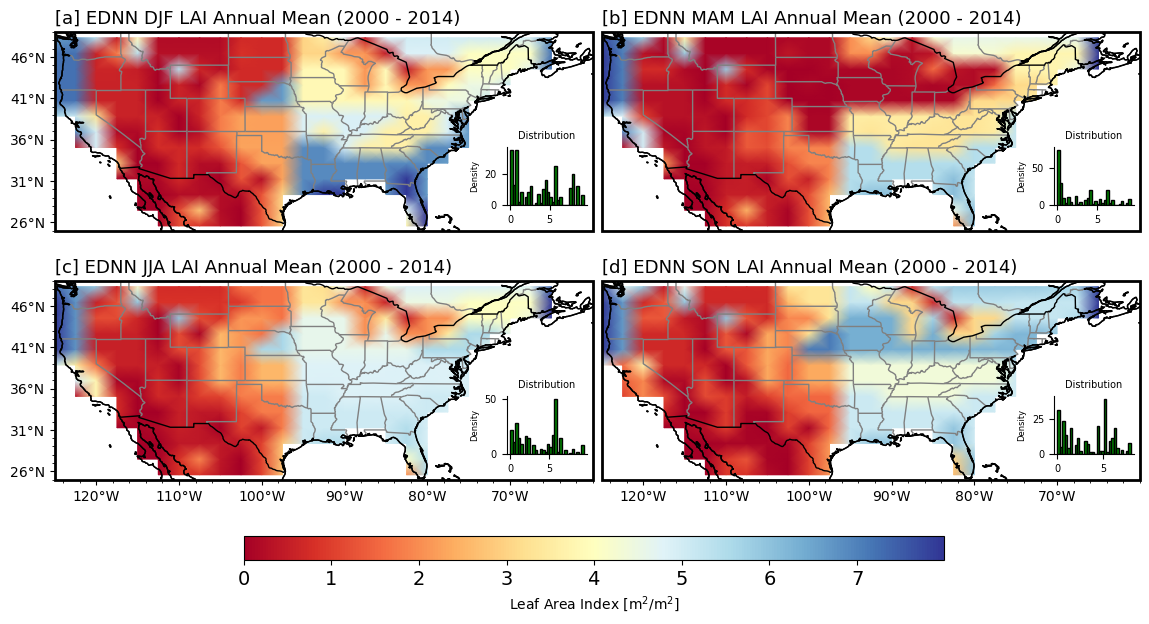

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.017, 'hspace': -0.2})
for axis in ax.flat:
    # Set the border color and width
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)
#============================================ Spatial Maps 

cs14a_ = _make_plot_without_contours_(pred_ednn['djf'][:, :].mean(dim="sample") ,  ax[0,0], '[a] EDNN DJF LAI Annual Mean (2000 - 2014)', is_first_subplot=True)
cs14b_ = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample") ,  ax[0,1], '[b] EDNN MAM LAI Annual Mean (2000 - 2014)')
cs14c_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample") ,  ax[1,0], '[c] EDNN JJA LAI Annual Mean (2000 - 2014)', is_first_subplot=True, is_last_row=True)
cs14d_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample") ,  ax[1,1], '[d] EDNN SON LAI Annual Mean (2000 - 2014)', is_last_row=True)

# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=10)
plt.savefig("./Figures/conus_lai_.pdf", dpi = 600, bbox_inches='tight')

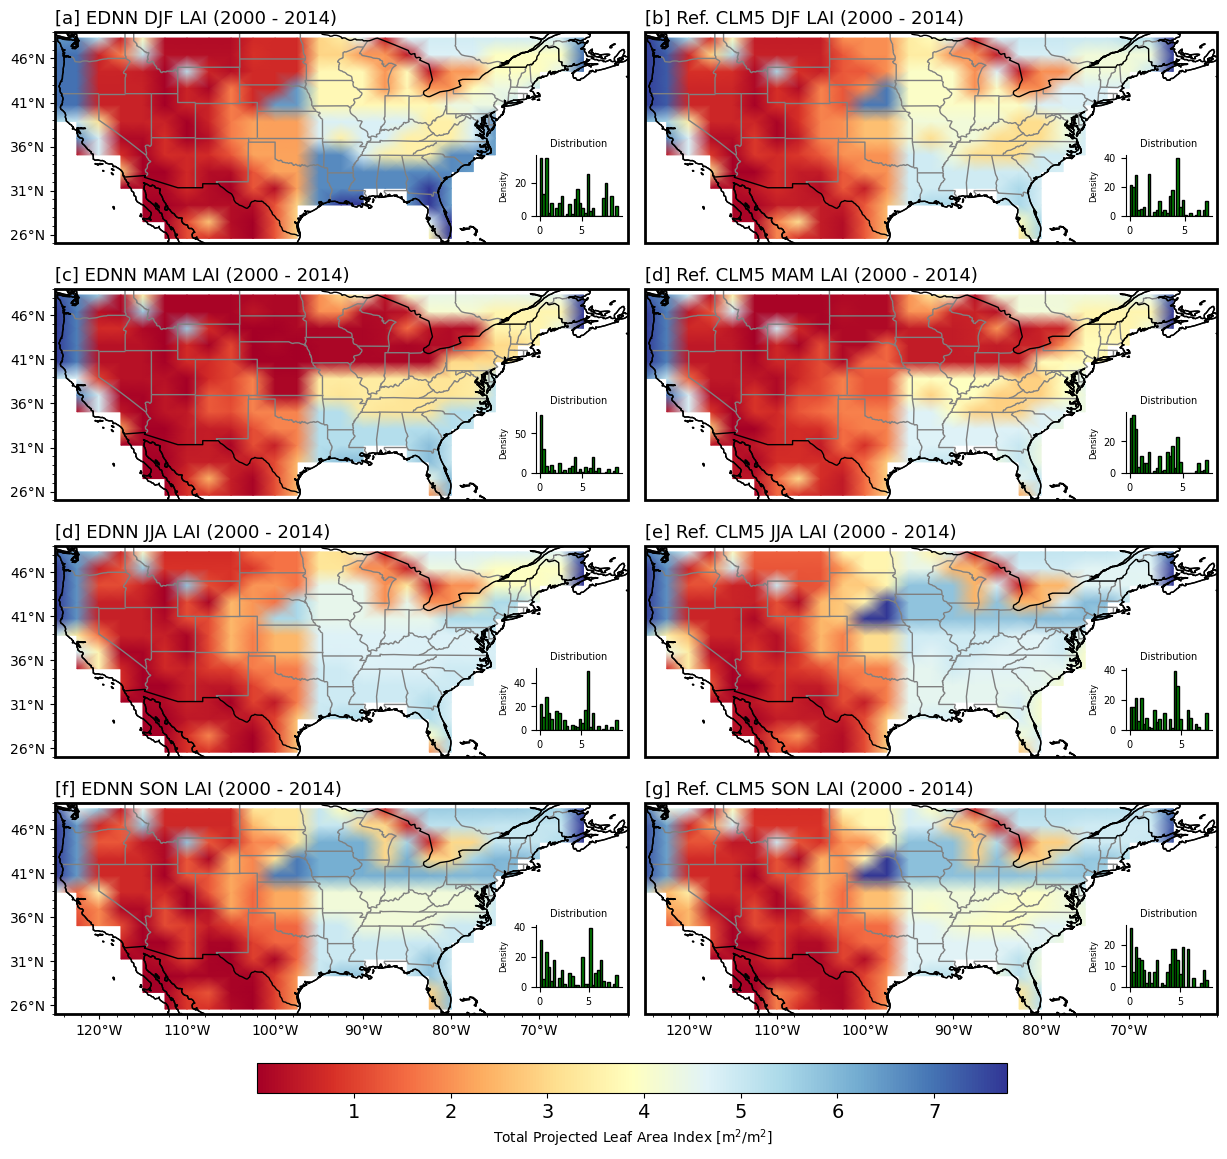

In [37]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[15, 15], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.03,'hspace': -0.08})
for axis in ax.flat:
    # Set the border color and width
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)
    
#============================================ Spatial Maps 
cs1e = _make_plot_without_contours_(pred_ednn['djf'][:, :].mean(dim="sample"),    ax[0,0], '[a] EDNN DJF LAI (2000 - 2014) ', is_first_subplot=True)
cs11_ = _make_plot_without_contours_(djf_seas_va_clm[:, :].mean(dim="sample"),  ax[0,1], '[b] Ref. CLM5 DJF LAI (2000 - 2014)')
cs12_ = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"),   ax[1,0], '[c] EDNN MAM LAI (2000 - 2014)', is_first_subplot=True)
cs13_ = _make_plot_without_contours_(mam_seas_va_clm[:, :].mean(dim="sample"),  ax[1,1], '[d] Ref. CLM5 MAM LAI (2000 - 2014)')

cs14a_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample") ,  ax[2,0], '[d] EDNN JJA LAI (2000 - 2014)', is_first_subplot=True)
cs14b_ = _make_plot_without_contours_(jja_seas_va_clm[:, :].mean(dim="sample"),  ax[2,1], '[e] Ref. CLM5 JJA LAI (2000 - 2014)')
cs14c_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample"),   ax[3,0], '[f] EDNN SON LAI (2000 - 2014)', is_last_row=True, is_first_subplot=True)
cs14d_ = _make_plot_without_contours_(son_seas_va_clm[:, :].mean(dim="sample"),  ax[3,1], '[g] Ref. CLM5 SON LAI (2000 - 2014)', is_last_row=True)

# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.02])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Total Projected Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=10)
plt.savefig("./Figures/sparse_lai.pdf", dpi = 600, bbox_inches='tight')

In [39]:
def _make_plot_without_contours_(data_nc: xr.DataArray, ax: plt.Axes, title: str, 
                                   is_first_subplot: bool = False, is_last_row: bool = False):
    """
    Creates a filled pcolormesh plot (without contour lines) from the input data array with a cyclic point added.
    Also overlays an inset histogram to display the data distribution.
    
    Parameters:
        data_nc (xr.DataArray): The input data array containing 'lat' and 'lon' coordinates.
        ax (plt.Axes): The axis on which the plot is generated.
        title (str): The title for the subplot (displayed on the left).
        is_first_subplot (bool, optional): If True, configures y-axis tick formatting for the first subplot in a column.
        is_last_row (bool, optional): If True, configures x-axis tick formatting for subplots in the last row.
        
    Returns:
        mesh (matplotlib.collections.QuadMesh): The pcolormesh object created by the plot.
    """
    # ---------- Add cyclic point to data and update longitude
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    # ---------- Create a filled pcolormesh plot using 'gouraud' shading
    mesh = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='RdYlBu', shading='gouraud')
    
    # ---------- Set subplot title (left-aligned)
    ax.set_title(title, fontweight='regular', fontsize=13, loc='left')
    
    # ---------- Configure x-axis for subplots in the last row
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    # ---------- Configure y-axis for the first subplot in a column
    if is_first_subplot:
        ax.set_yticks(np.arange(26, 49, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
    
    # ---------- Add state boundaries and country borders for geographic context
    states = cfeature.NaturalEarthFeature(category='cultural',
                                          name='admin_1_states_provinces_lines',
                                          scale='50m', facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    
    # ---------- Enable minor ticks and add coastline features
    ax.minorticks_on()
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    
    # ---------- Create an inset axis for plotting the distribution histogram
    inset_ax = ax.inset_axes([0.84, 0.13, 0.15, 0.29], transform=ax.transAxes)
    
    # ---------- Flatten the data array and remove NaN values for the histogram
    data_flat = data.flatten()
    data_flat = data_flat[~np.isnan(data_flat)]
    
    # ---------- Plot the histogram on the inset axis
    inset_ax.hist(data_flat, bins=30, color='g', edgecolor='black')
    inset_ax.set_title('Distribution', fontsize=7)
    inset_ax.tick_params(axis='both', which='major', labelsize=7)
    inset_ax.set_ylabel('Density', fontsize=6)
    
    # ---------- Remove top and right spines from the inset for a cleaner look
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)
    
    return mesh

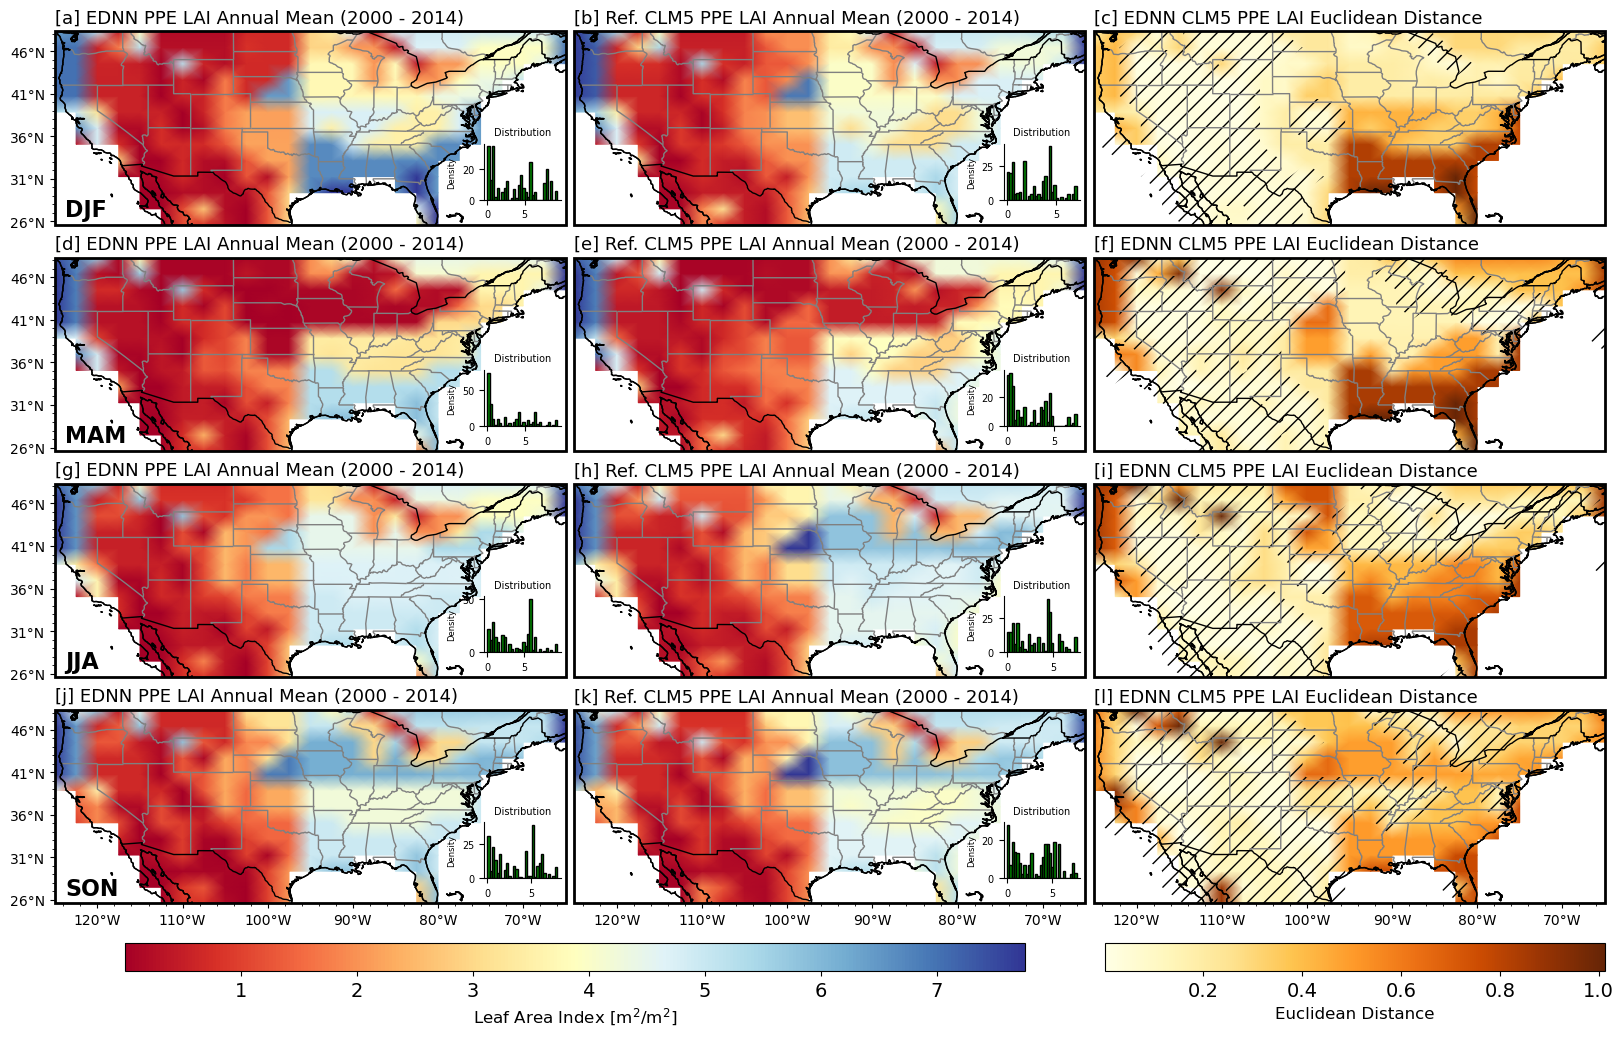

In [40]:

# ---------- Create a 4 (seasons) x 3 (variables) grid of subplots with Cartopy projection and custom grid spacing
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[20, 14], 
                       subplot_kw={'projection': ccrs.PlateCarree()}, 
                       gridspec_kw={'wspace': 0.017, 'hspace': -0.25})

# ---------- Set the border color and width for each subplot
common_extent = [-125, -60, 25, 49]
for axis in ax.flat:
    # axis.set_extent(common_extent, crs=ccrs.PlateCarree())  # Uncomment if a common extent is desired
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# ---------- Plot spatial maps for LAI

# DJF: EDNN and Reference CLM5
cs1e  = _make_plot_without_contours_(pred_ednn['djf'][:, :].mean(dim="sample"), ax[0, 0],
                                      '[a] EDNN PPE LAI Annual Mean (2000 - 2014) ', 
                                      is_first_subplot=True)
cs11_ = _make_plot_without_contours_(djf_seas_va_clm[:, :].mean(dim="sample"), ax[0, 1],
                                      '[b] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)')

# MAM: EDNN and Reference CLM5
cs12_ = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"), ax[1, 0],
                                      '[d] EDNN PPE LAI Annual Mean (2000 - 2014)', 
                                      is_first_subplot=True)
cs13_ = _make_plot_without_contours_(mam_seas_va_clm[:, :].mean(dim="sample"), ax[1, 1],
                                      '[e] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)')

# JJA: EDNN and Reference CLM5
cs14a_ = _make_plot_without_contours_(pred_ednn['jja'][:, :].mean(dim="sample"), ax[2, 0],
                                       '[g] EDNN PPE LAI Annual Mean (2000 - 2014)', 
                                       is_first_subplot=True)
cs14b_ = _make_plot_without_contours_(jja_seas_va_clm[:, :].mean(dim="sample"), ax[2, 1],
                                       '[h] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)')

# SON: EDNN and Reference CLM5 (last row)
cs14c_ = _make_plot_without_contours_(pred_ednn['son'][:, :].mean(dim="sample"), ax[3, 0],
                                       '[j] EDNN PPE LAI Annual Mean (2000 - 2014)', 
                                       is_last_row=True, is_first_subplot=True)
cs14d_ = _make_plot_without_contours_(son_seas_va_clm[:, :].mean(dim="sample"), ax[3, 1],
                                       '[k] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)', 
                                       is_last_row=True)

# ---------- Add Euclidean Distance maps as the last column
threshold = 0.3
mesh14a_ = make_plot_without_contours(djf, ax[0, 2], threshold,
                                      '[c] EDNN CLM5 PPE LAI Euclidean Distance', 
                                      is_first_subplot=False)
mesh14b_ = make_plot_without_contours(mam, ax[1, 2], threshold,
                                      '[f] EDNN CLM5 PPE LAI Euclidean Distance', 
                                      is_first_subplot=False)
mesh14c_ = make_plot_without_contours(jja, ax[2, 2], threshold,
                                      '[i] EDNN CLM5 PPE LAI Euclidean Distance', 
                                      is_first_subplot=False)
mesh14d_ = make_plot_without_contours(son, ax[3, 2], threshold,
                                      '[l] EDNN CLM5 PPE LAI Euclidean Distance', 
                                      is_first_subplot=False, is_last_row=True)

# ---------- Add season labels to the left-most subplot of each row.
seasons = ['DJF', 'MAM', 'JJA', 'SON']
for i, season in enumerate(seasons):
    ax[i, 0].text(0.02, 0.02, season, transform=ax[i, 0].transAxes,
                  fontsize=16, fontweight='bold', va='bottom', ha='left', color='black')

# ---------- Adjust layout to leave space at the bottom for the colorbars.
fig.subplots_adjust(bottom=0.2, top=0.9)

# ---------- Create horizontal colorbar for the LAI maps (first two columns).
cbar_ax1 = fig.add_axes([0.16, 0.19, 0.45, 0.02])
cbar1 = fig.colorbar(cs14d_, cax=cbar_ax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label('Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=12)

# ---------- Create horizontal colorbar for the Euclidean Distance maps (last column).
cbar_ax2 = fig.add_axes([0.65, 0.19, 0.25, 0.02])
cbar2 = fig.colorbar(mesh14d_, cax=cbar_ax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label('Euclidean Distance', fontweight='regular', fontsize=12)

# ---------- Save the combined figure as a high-resolution PDF and display the plot
plt.savefig("./Figures/combined_figure.pdf", dpi=600, bbox_inches='tight')
plt.show()


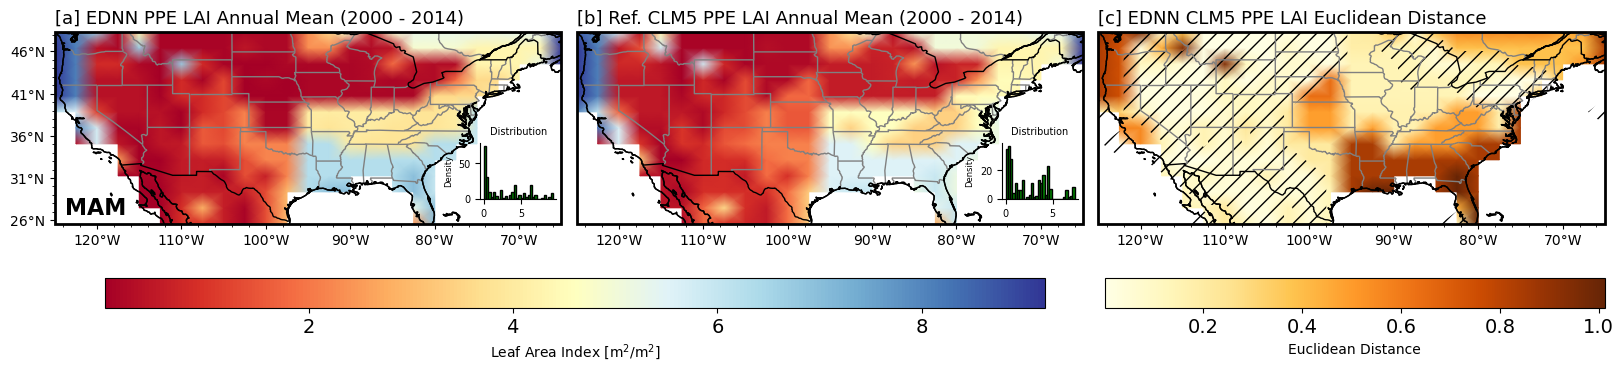

In [42]:
# Create a 4 (seasons) x 3 (variables) grid of subplots.
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[20, 15], 
                       subplot_kw={'projection': ccrs.PlateCarree()}, 
                       gridspec_kw={'wspace': 0.03, 'hspace': -0.01})

# Set the border color and width for each subplot.
for axis in ax.flat:
    # axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

#============================================ Spatial Maps 
cs1e   = _make_plot_without_contours_(pred_ednn['mam'][:, :].mean(dim="sample"),    ax[0], '[a] EDNN PPE LAI Annual Mean (2000 - 2014) ', is_last_row=True,is_first_subplot=True)
cs11_  = _make_plot_without_contours_(mam_seas_va_clm[:, :].mean(dim="sample"),  ax[1], '[b] Ref. CLM5 PPE LAI Annual Mean (2000 - 2014)', is_last_row=True)

# Adding Euclidean Distance maps as the last column
threshold = 0.3
mesh14a_ = make_plot_without_contours(mam, ax[2], threshold,
                                       '[c] EDNN CLM5 PPE LAI Euclidean Distance', is_last_row=True, is_first_subplot=False)

#------------------------------------------------------------------------
# Add season labels to the left-most subplot of each row.
# Adjust the coordinates (here, 0.02, 0.02 in axis coordinates) and fontsize as needed.
seasons = ['MAM']#, 'MAM', 'JJA', 'SON']
for i, season in enumerate(seasons):
    ax[i].text(0.02, 0.02, season, transform=ax[i].transAxes,
                  fontsize=16, fontweight='bold', va='bottom', ha='left', color='black')
#------------------------------------------------------------------------

# Adjust layout to leave space at the bottom for the colorbars.
fig.subplots_adjust(bottom=0.2, top=0.9)

# Create a horizontal colorbar for the LAI maps (first two columns).
cbar_ax1 = fig.add_axes([0.15, 0.43, 0.47,  0.02])
cbar1 = fig.colorbar(cs1e, cax=cbar_ax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label('Leaf Area Index [m$^2$/m$^2$]', fontweight='regular', fontsize=10)
# Create a horizontal colorbar for the Euclidean Distance maps (last column).
cbar_ax2 = fig.add_axes([0.65, 0.43, 0.25,  0.02])
cbar2 = fig.colorbar(mesh14d_, cax=cbar_ax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label('Euclidean Distance', fontweight='regular', fontsize=10)

plt.savefig("./Figures/mam_combined_figure.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [53]:
def uncert_plot_without_contours_(data_nc: xr.DataArray, ax: plt.Axes, title: str, 
                                   is_first_subplot: bool = False, is_last_row: bool = False, 
                                   norm=None) -> object:
    """
    Creates a filled pcolormesh plot from the input data array with a cyclic point added to its longitude,
    and configures the map using Cartopy. An inset histogram is not included in this function.
    
    Parameters:
        data_nc (xr.DataArray): The input data array to plot. Must include 'lat' and 'lon' coordinates.
        ax (plt.Axes): The Matplotlib axes (with a Cartopy projection) on which to create the plot.
        title (str): Title to display on the subplot (left-aligned).
        is_first_subplot (bool, optional): If True, configures y-axis tick formatting for the first subplot in a column.
        is_last_row (bool, optional): If True, configures x-axis tick formatting for subplots in the last row.
        norm (object, optional): A Matplotlib normalization instance (e.g., LogNorm) to apply to the colormap.
        
    Returns:
        object: The QuadMesh object created by the pcolormesh plot.
    """
    # ---------- Add cyclic point to data and update longitude coordinates
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    # ---------- Create a filled pcolormesh plot with "gouraud" shading and apply normalization if provided
    mesh = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='coolwarm', shading='gouraud', norm=norm)  # Optionally change cmap (e.g., 'YlOrRd')
    
    # ---------- Set the subplot title (left-aligned)
    ax.set_title(title, fontweight='regular', fontsize=10, loc='left')
    
    # ---------- Configure x-axis ticks if the subplot is in the last row
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    # ---------- Configure y-axis ticks if this is the first subplot in a column
    if is_first_subplot:
        ax.set_yticks(np.arange(26, 49, 5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
    
    # ---------- Add geographic features: state boundaries and country borders
    states = cfeature.NaturalEarthFeature(category='cultural',
                                          name='admin_1_states_provinces_lines',
                                          scale='50m', facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    
    # ---------- Enable minor ticks and add coastlines for geographic context
    ax.minorticks_on()
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    
    return mesh


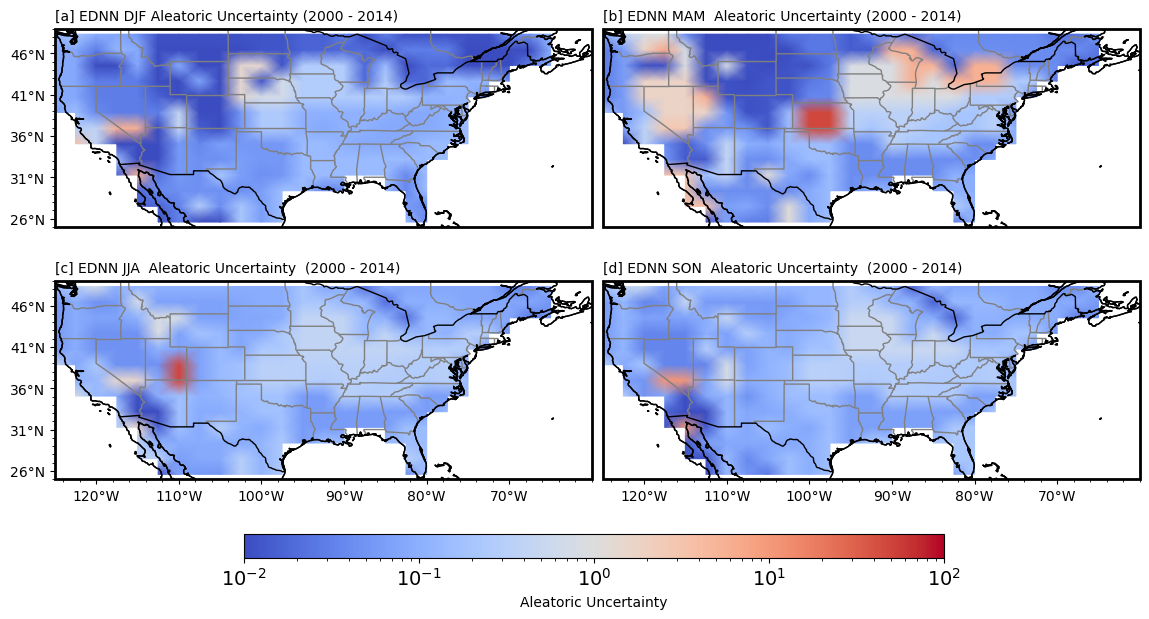

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8],
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       gridspec_kw={'wspace': 0.02, 'hspace': -0.18})
for axis in ax.flat:
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

log_norm = LogNorm(vmin=1e-2, vmax=1e2)

#============================================ Spatial Maps 

mesh14a_ = uncert_plot_without_contours_(pred_ednn_alea['djf'][:, :].mean(dim="sample"), ax[0,0], 
                             '[a] EDNN DJF Aleatoric Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
mesh14b_ = uncert_plot_without_contours_(pred_ednn_alea['mam'][:, :].mean(dim="sample"), ax[0,1], 
                             '[b] EDNN MAM  Aleatoric Uncertainty (2000 - 2014)', norm=log_norm)
mesh14c_ = uncert_plot_without_contours_(pred_ednn_alea['jja'][:, :].mean(dim="sample"), ax[1,0], 
                             '[c] EDNN JJA  Aleatoric Uncertainty  (2000 - 2014)', is_first_subplot=True, is_last_row=True, norm=log_norm)
mesh14d_ = uncert_plot_without_contours_(pred_ednn_alea['son'][:, :].mean(dim="sample"), ax[1,1], 
                             '[d] EDNN SON  Aleatoric Uncertainty  (2000 - 2014)', is_last_row=True, norm=log_norm)

fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(mesh14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=10)
plt.savefig("./Figures/aleatoric_map.pdf", dpi=600, bbox_inches='tight')
plt.show()


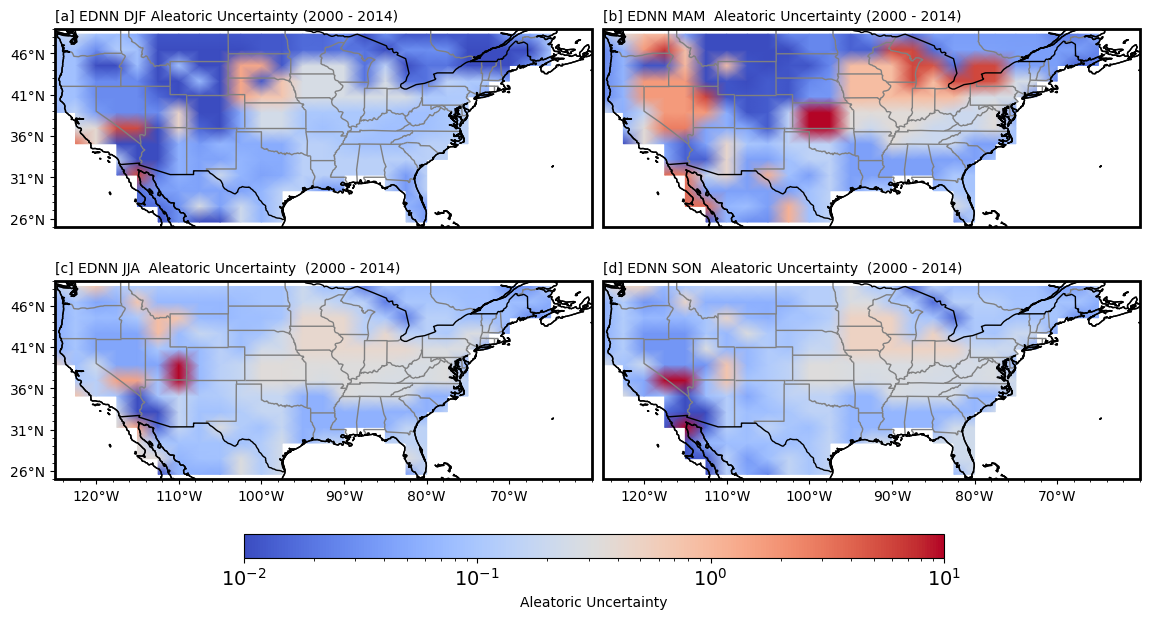

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.02, 'hspace': -0.18})
for axis in ax.flat:
    axis.set_extent(common_extent, crs=ccrs.PlateCarree())
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

log_norm = LogNorm(vmin=1e-2, vmax=1e1)

#============================================ Spatial Maps 

cs14a_ = uncert_plot_without_contours_(pred_ednn_alea['djf'][:, :].mean(dim="sample"), ax[0,0], 
                             '[a] EDNN DJF Aleatoric Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14b_ = uncert_plot_without_contours_(pred_ednn_alea['mam'][:, :].mean(dim="sample"), ax[0,1], 
                             '[b] EDNN MAM  Aleatoric Uncertainty (2000 - 2014)', norm=log_norm)
cs14c_ = uncert_plot_without_contours_(pred_ednn_alea['jja'][:, :].mean(dim="sample"), ax[1,0], 
                             '[c] EDNN JJA  Aleatoric Uncertainty  (2000 - 2014)', is_first_subplot=True, is_last_row=True, norm=log_norm)
cs14d_ = uncert_plot_without_contours_(pred_ednn_alea['son'][:, :].mean(dim="sample"), ax[1,1], 
                             '[d] EDNN SON  Aleatoric Uncertainty  (2000 - 2014)', is_last_row=True, norm=log_norm)

fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=10)
plt.savefig("./Figures/aleatoric_map.pdf", dpi=600, bbox_inches='tight')

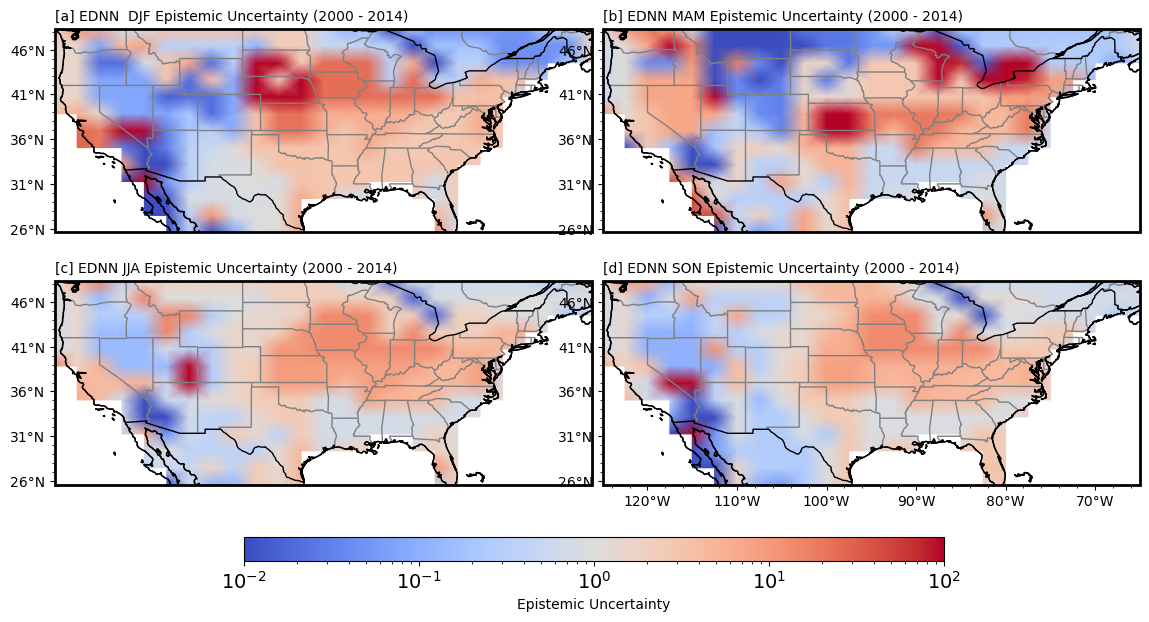

In [46]:
# Now apply this modified function to your plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.02, 'hspace': -0.18})

for axis in ax.flat:
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# Use LogNorm for log scaling
log_norm = LogNorm(vmin=1e-2, vmax=1e2)

#============================================ Spatial Maps 
cs14a_ = uncert_plot_without_contours_(pred_ednn_epis['djf'][:, :].mean(dim="sample"), ax[0,0], 
                              '[a] EDNN  DJF Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14b_ = uncert_plot_without_contours_(pred_ednn_epis['mam'][:, :].mean(dim="sample"), ax[0,1], 
                              '[b] EDNN MAM Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, norm=log_norm)
cs14c_ = uncert_plot_without_contours_(pred_ednn_epis['jja'][:, :].mean(dim="sample"), ax[1,0], 
                              '[c] EDNN JJA Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True,  norm=log_norm)
cs14d_ = uncert_plot_without_contours_(pred_ednn_epis['son'][:, :].mean(dim="sample"), ax[1,1], 
                              '[d] EDNN SON Epistemic Uncertainty (2000 - 2014)', is_first_subplot=True, is_last_row=True,  norm=log_norm)

# Create a single horizontal colorbar
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.03])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)

# Add colorbar label with units and mention the log scale
cbar.set_label('Epistemic Uncertainty', fontweight='regular', fontsize=10)

# Save the figure
plt.savefig("./Figures/epistemic_Map.pdf", dpi=600, bbox_inches='tight')

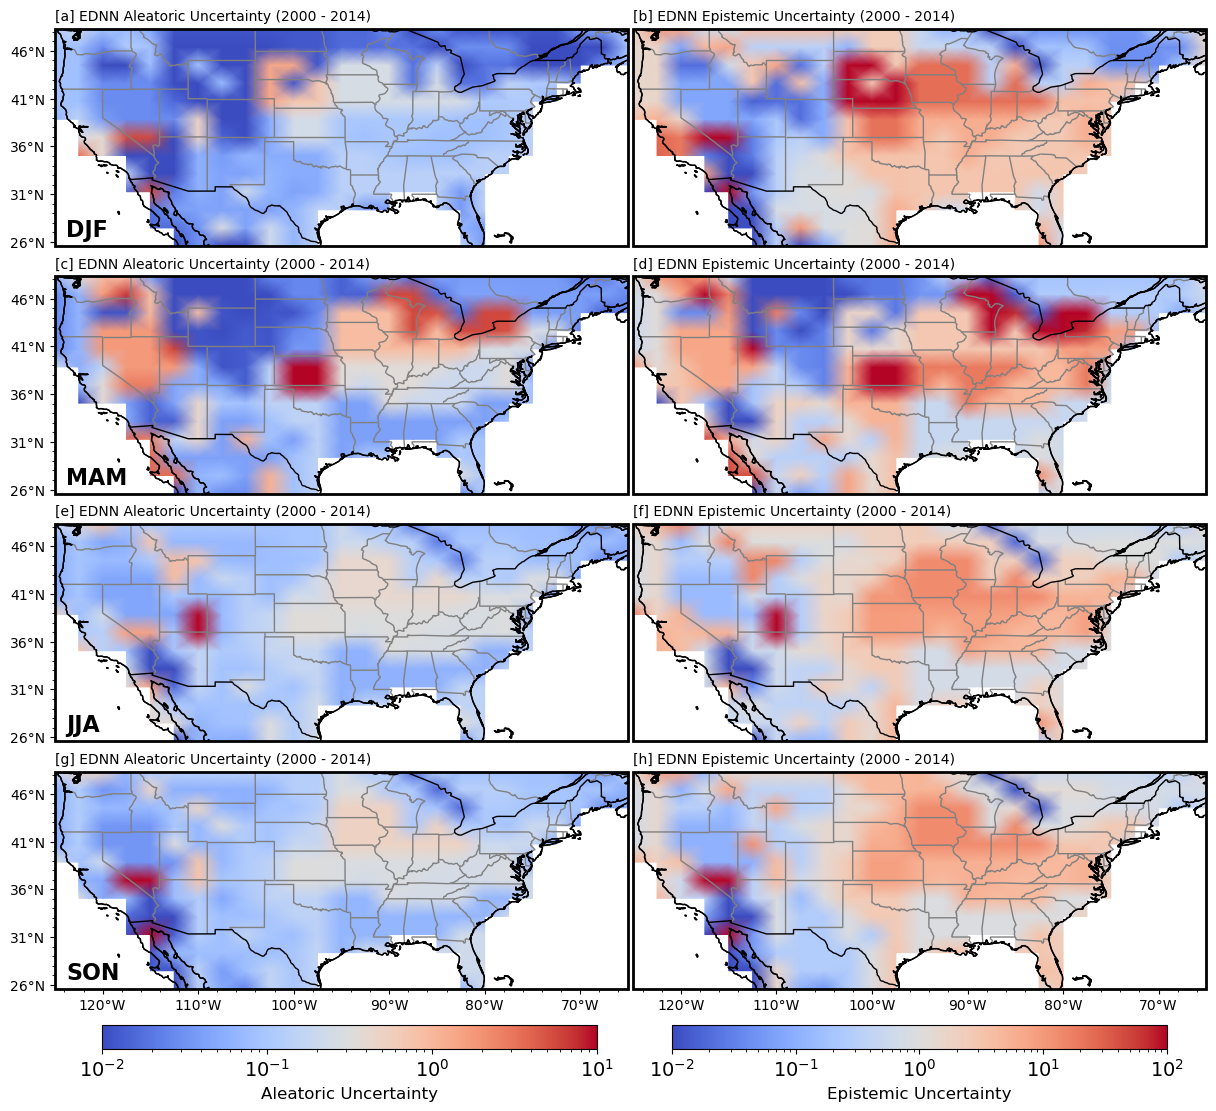

In [47]:
# =============================================================================
# Uncertainty Maps for EDNN LAI (FAST Analysis)
# =============================================================================

# ---------- Set global publication standards for font styling (if needed)
title_fontsize = 30         # Increase to enlarge subplot titles.
season_label_fontsize = 16  # Font size for the season label text.

# ---------- Create a 4 (seasons) x 2 (uncertainty types) grid of subplots with a PlateCarree projection
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 12),
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       gridspec_kw={'wspace': -0.01, 'hspace': 0.14})

# ---------- Set the Cartopy frame ("geo" spines) for each subplot
for axis in ax.flat:
    # If desired, set the geographical extent here (e.g., axis.set_extent(common_extent, crs=ccrs.PlateCarree()))
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

# ---------- Define normalization for uncertainty data with logarithmic scaling
norm_alea = LogNorm(vmin=1e-2, vmax=1e1)   # Normalization for aleatoric uncertainty
norm_epi  = LogNorm(vmin=1e-2, vmax=1e2)     # Normalization for epistemic uncertainty

# ---------- Define seasons and corresponding subplot titles for each column
seasons = ['djf', 'mam', 'jja', 'son']
titles_alea = [
    '[a] EDNN Aleatoric Uncertainty (2000 - 2014)',
    '[c] EDNN Aleatoric Uncertainty (2000 - 2014)',
    '[e] EDNN Aleatoric Uncertainty (2000 - 2014)',
    '[g] EDNN Aleatoric Uncertainty (2000 - 2014)'
]
titles_epi = [
    '[b] EDNN Epistemic Uncertainty (2000 - 2014)',
    '[d] EDNN Epistemic Uncertainty (2000 - 2014)',
    '[f] EDNN Epistemic Uncertainty (2000 - 2014)',
    '[h] EDNN Epistemic Uncertainty (2000 - 2014)'
]

# ---------- Loop over each season and plot the corresponding uncertainty data
for i, season in enumerate(seasons):
    is_last = (i == len(seasons) - 1)  # Determine if it's the last row for further formatting

    # ---------- Left column: Plot aleatoric uncertainty map
    cs_alea = uncert_plot_without_contours_(
        pred_ednn_alea[season][:, :].mean(dim="sample"),
        ax=ax[i, 0],
        title=titles_alea[i],
        is_first_subplot=True,
        is_last_row=is_last,
        norm=norm_alea
    )
    
    # ---------- Right column: Plot epistemic uncertainty map
    cs_epi = uncert_plot_without_contours_(
        pred_ednn_epis[season][:, :].mean(dim="sample"),
        ax=ax[i, 1],
        title=titles_epi[i],
        is_first_subplot=False,
        is_last_row=is_last,
        norm=norm_epi
    )
    
    # ---------- Update title font sizes to the desired publication standard
    ax[i, 0].title.set_fontsize(title_fontsize)
    ax[i, 1].title.set_fontsize(title_fontsize)
    
    # ---------- Add a season label to the lower-left corner of the left subplot
    ax[i, 0].text(0.02, 0.02, season.upper(), transform=ax[i, 0].transAxes,
                  fontsize=season_label_fontsize, fontweight='bold',
                  va='bottom', ha='left', color='black')

# ---------- Adjust layout to provide space for horizontal colorbars at the bottom
plt.tight_layout()
fig.subplots_adjust(bottom=0.15, top=0.95)

# ---------- Create horizontal colorbars for the two uncertainty types
cbar_ax_alea = fig.add_axes([0.16, 0.1, 0.33, 0.02])  # Colorbar for aleatoric uncertainty
cbar_alea = fig.colorbar(cs_alea, cax=cbar_ax_alea, orientation="horizontal")
cbar_alea.ax.tick_params(labelsize=14)
cbar_alea.set_label('Aleatoric Uncertainty', fontweight='regular', fontsize=12)

cbar_ax_epi = fig.add_axes([0.54, 0.1, 0.33, 0.02])  # Colorbar for epistemic uncertainty
cbar_epi = fig.colorbar(cs_epi, cax=cbar_ax_epi, orientation="horizontal")
cbar_epi.ax.tick_params(labelsize=14)
cbar_epi.set_label('Epistemic Uncertainty', fontweight='regular', fontsize=12)

# ---------- Save the combined figure as a high-resolution PDF
plt.savefig("./Figures/uncertainty_maps.pdf", dpi=600, bbox_inches='tight')
plt.show()

## Sensitivity Analysis 

#### Season FAST

In [48]:
#------------ DJF
lai_djf_fast = fast_model(x_djf_tr, model_ednn_djf,pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_djf = pd.DataFrame.from_dict(lai_djf_fast)
Si_djf.index = Si_djf.names
df_Si_djf = Si_djf.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.025609  0.041425  0.000149  0.004064
KCN                  0.002779  0.017495  0.000154  0.003922
a_fix                0.007258  0.029105  0.000155  0.004040
crit_dayl            0.001054  0.022265  0.000155  0.004098
d_max                0.000259  0.012547  0.000154  0.004167
fff                  0.000075  0.011110  0.000158  0.004081
froot_leaf           0.014789  0.030806  0.000159  0.004236
fstor2tran           0.000814  0.018320  0.000151  0.004195
grperc               0.009689  0.034104  0.000158  0.004210
jmaxb0               0.135484  0.176208  0.000153  0.004245
jmaxb1               0.074610  0.106705  0.000159  0.004110
kcha                 0.036007  0.057920  0.000148  0.004070
kmax                 0.002219  0.032538  0.000149  0.004141
krmax                0.000817  0.017154  0.000152  0.004075
leaf_long            0.044836  0.073077  0.000161  0.004

In [49]:
#------------ MAM
lai_mam_fast = fast_model(x_mam_tr, model_ednn_mam,pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_mam = pd.DataFrame.from_dict(lai_mam_fast)
Si_mam.index = Si_mam.names
df_Si_mam = Si_mam.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.048949  0.080710  0.000159  0.004177
KCN                  0.003523  0.027999  0.000157  0.004128
a_fix                0.024442  0.048198  0.000161  0.004043
crit_dayl            0.004817  0.030894  0.000152  0.004172
d_max                0.001197  0.024445  0.000156  0.004224
fff                  0.000344  0.020940  0.000153  0.004144
froot_leaf           0.024927  0.050619  0.000159  0.004021
fstor2tran           0.001061  0.018385  0.000159  0.004109
grperc               0.005009  0.027273  0.000153  0.004033
jmaxb0               0.146038  0.196964  0.000153  0.003983
jmaxb1               0.070542  0.105476  0.000146  0.004010
kcha                 0.021065  0.052368  0.000150  0.004091
kmax                 0.003507  0.059273  0.000152  0.004092
krmax                0.000091  0.028218  0.000154  0.004133
leaf_long            0.040824  0.079194  0.000158  0.003

In [50]:
#------------ JJA
lai_jja_fast = fast_model(x_jja_tr, model_ednn_jja, pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_jja = pd.DataFrame.from_dict(lai_jja_fast)
Si_jja.index = Si_jja.names
df_Si_jja = Si_jja.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.051630  0.097506  0.000150  0.004292
KCN                  0.000872  0.025197  0.000160  0.004243
a_fix                0.013478  0.042245  0.000154  0.004070
crit_dayl            0.000130  0.018116  0.000157  0.004049
d_max                0.001825  0.018024  0.000158  0.004158
fff                  0.003633  0.024853  0.000147  0.004153
froot_leaf           0.012122  0.036101  0.000156  0.004020
fstor2tran           0.002297  0.020072  0.000158  0.004099
grperc               0.011531  0.035922  0.000154  0.004048
jmaxb0               0.163305  0.240800  0.000158  0.004087
jmaxb1               0.077420  0.115625  0.000155  0.004058
kcha                 0.026287  0.068181  0.000160  0.004061
kmax                 0.000156  0.031204  0.000161  0.004115
krmax                0.003190  0.035828  0.000165  0.003993
leaf_long            0.017495  0.052543  0.000154  0.004

In [51]:
#------------ SON
lai_son_fast = fast_model(x_son_tr, model_ednn_son, pred=1, M=4, num_resamples=1000, conf_level=0.95)
Si_son = pd.DataFrame.from_dict(lai_son_fast)
Si_son.index = Si_son.names
df_Si_son = Si_son.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.037226  0.069831  0.000154  0.003990
KCN                  0.000318  0.020864  0.000159  0.003996
a_fix                0.012864  0.041328  0.000151  0.003952
crit_dayl            0.000396  0.021807  0.000153  0.004146
d_max                0.000914  0.019266  0.000156  0.004045
fff                  0.000211  0.021451  0.000157  0.004070
froot_leaf           0.030231  0.054641  0.000156  0.004194
fstor2tran           0.000215  0.023226  0.000162  0.004141
grperc               0.002673  0.034259  0.000159  0.004198
jmaxb0               0.159602  0.216772  0.000165  0.003949
jmaxb1               0.097343  0.150969  0.000159  0.004155
kcha                 0.028132  0.060017  0.000158  0.004016
kmax                 0.005852  0.037284  0.000165  0.004020
krmax                0.000024  0.025293  0.000158  0.004041
leaf_long            0.042686  0.078837  0.000162  0.004

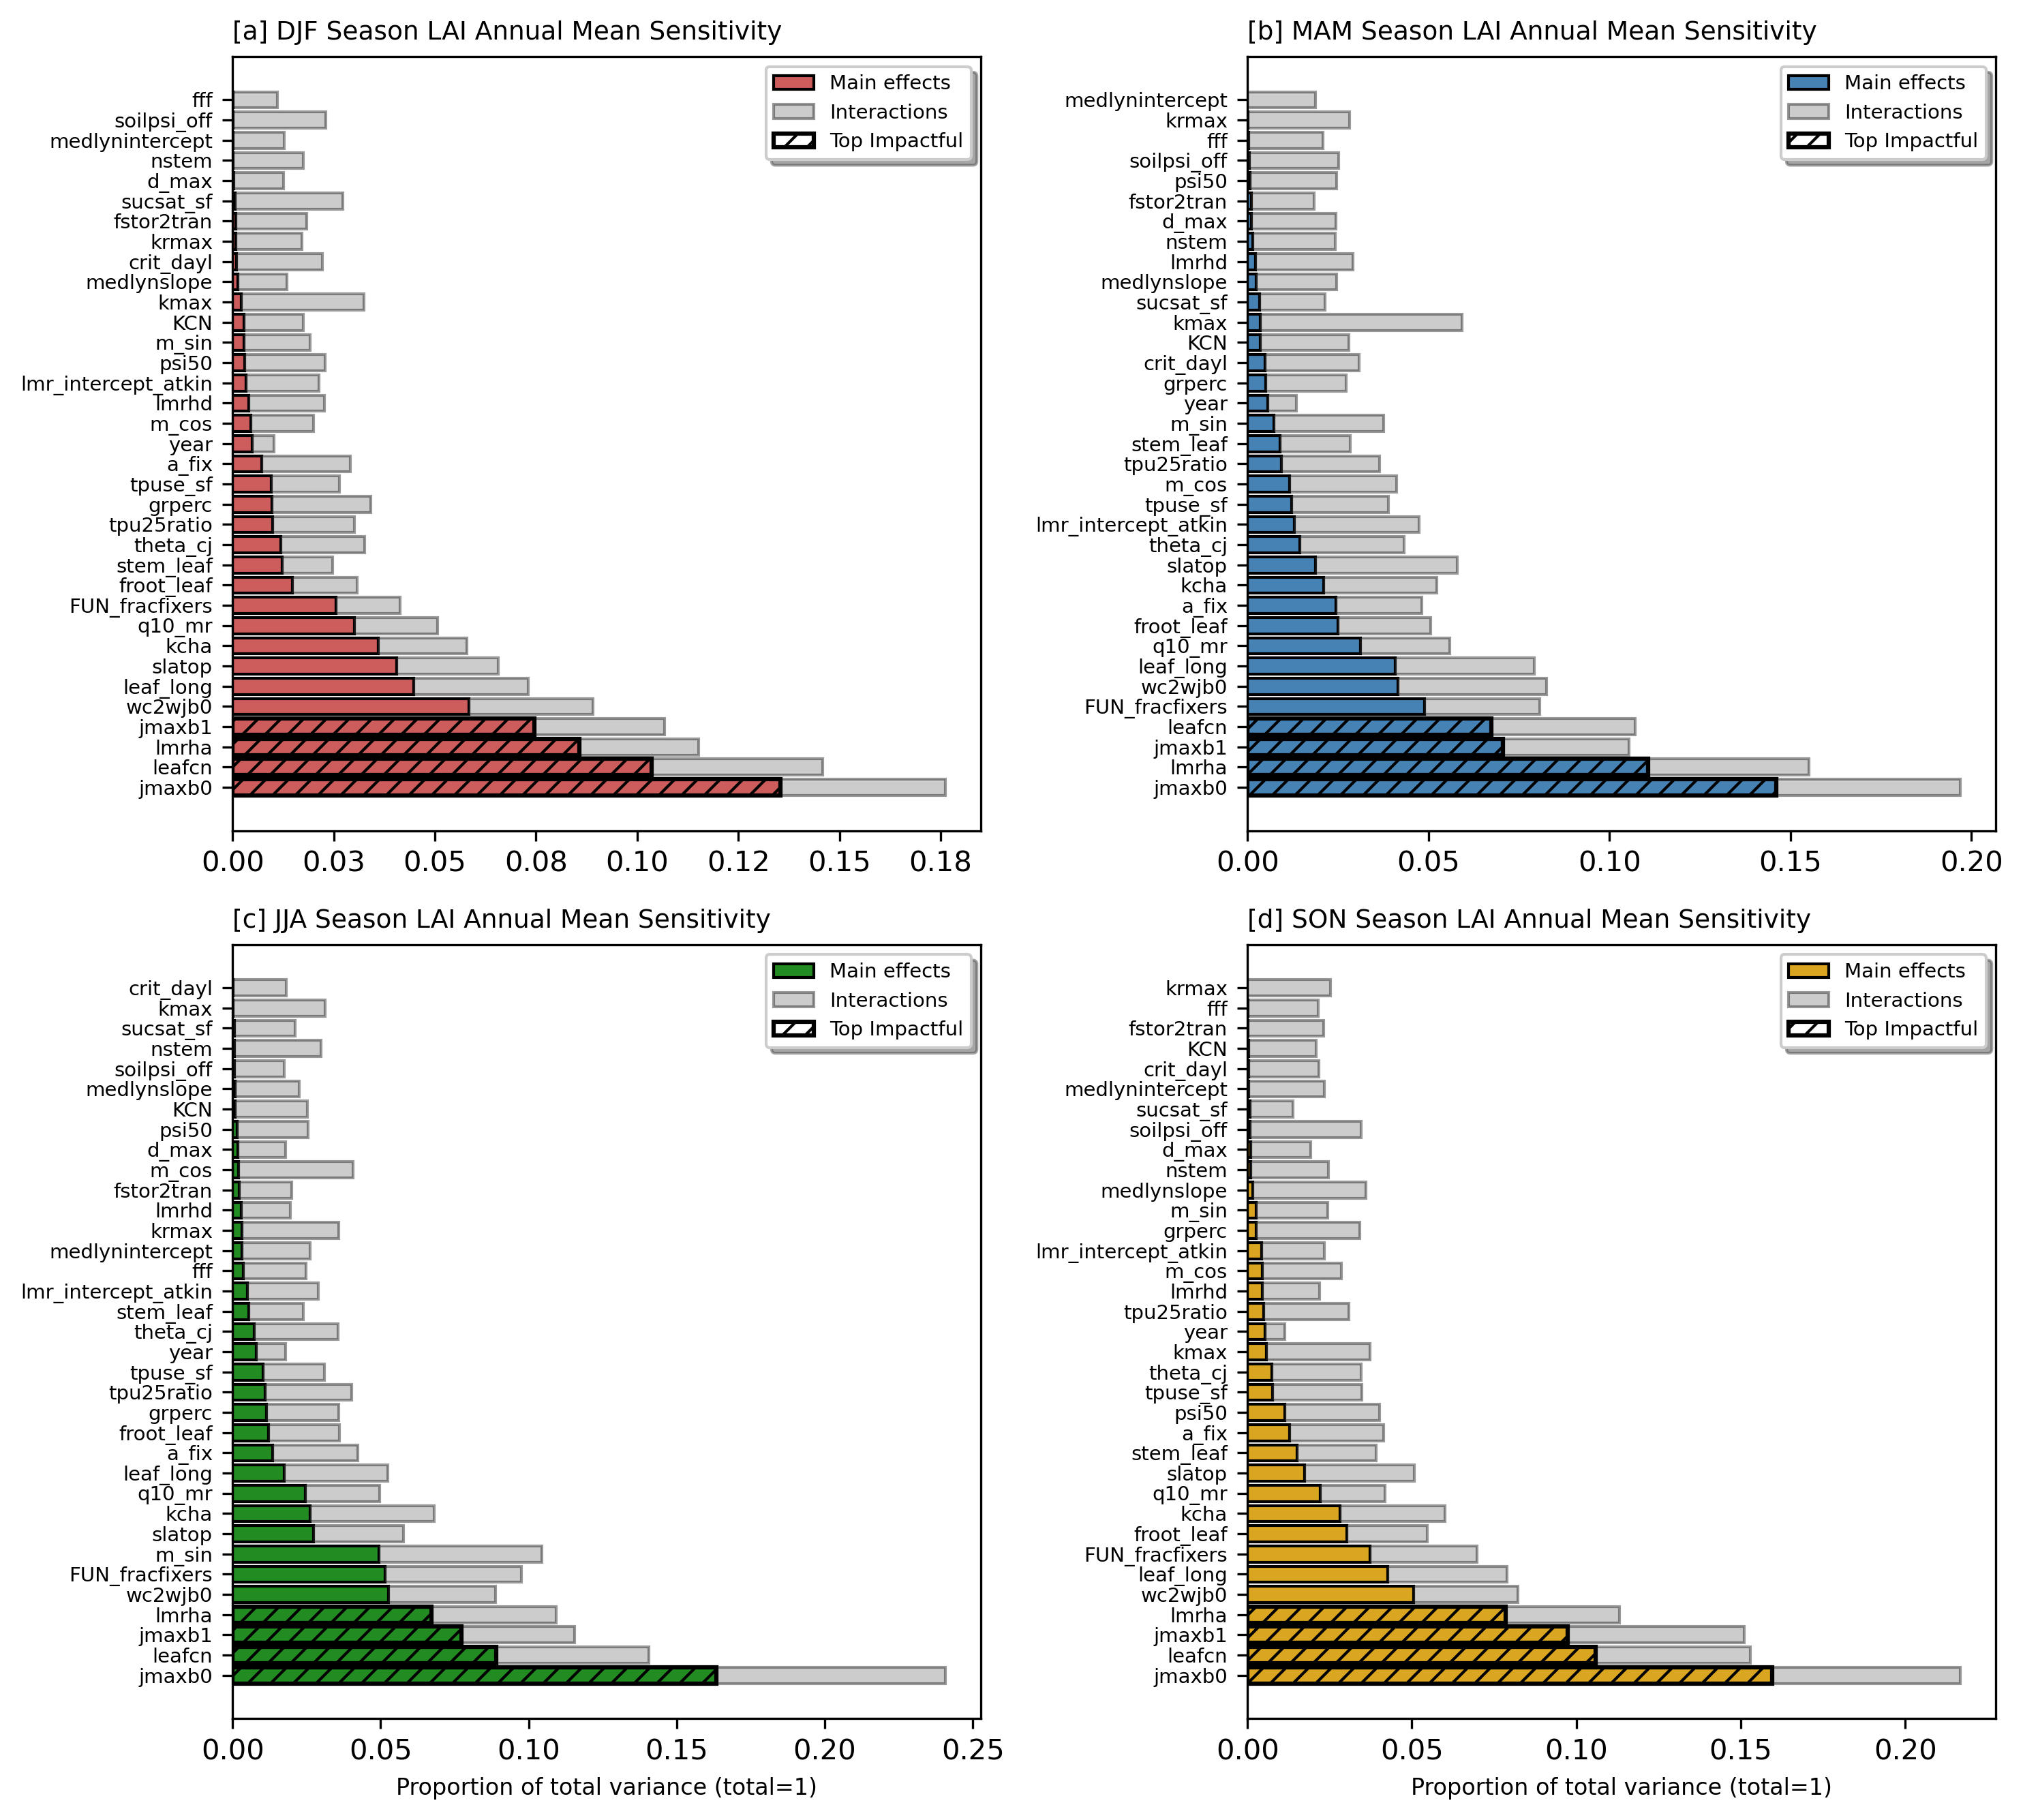

In [52]:
# =============================================================================
# FAST Sensitivity Analysis Plots for Seasonal LAI
# =============================================================================

# ---------- Define the helper function for FAST sensitivity plotting
def plot_sensitivity(ax, df: pd.DataFrame, title: str, bar_color: str, xlabel: bool = False) -> None:
    """
    Plot FAST sensitivity analysis as horizontal bar charts with main effects and interactions,
    and highlight the top 4 impactful parameters based on the main effect sensitivity (S1).

    Parameters:
        ax (matplotlib.axes.Axes): Axis object to plot the bar chart.
        df (pd.DataFrame): DataFrame containing the sensitivity data. Must have columns 'names', 'S1', and 'ST'.
        title (str): Title for the subplot; displayed on the left.
        bar_color (str): Color to use for the main effects bars.
        xlabel (bool, optional): If True, sets an x-axis label. Default is False.
    """
    # ---------- Identify the top 4 impactful parameters based on main effect sensitivity (S1)
    top_params = df.nlargest(4, 'S1')

    # ---------- Plot horizontal bars for main effects
    ax.barh(df.names, df['S1'], color=bar_color, label='Main effects', edgecolor='black')

    # ---------- Plot horizontal bars for interaction effects (stacked on top of main effects)
    ax.barh(df.names, df['ST'] - df['S1'], left=df['S1'], color='grey', 
            label='Interactions', alpha=0.4, edgecolor='black')

    # ---------- Overlay hatched bars to highlight the top 4 parameters
    for i, name in enumerate(top_params.names):
        idx = df.index[df['names'] == name][0]
        # Overlay a transparent bar with hatching on the main effect value
        ax.barh(df.loc[idx, 'names'], df.loc[idx, 'S1'], color='none', 
                hatch='///', edgecolor='black', linewidth=1.5,
                label='Top Impactful' if i == 0 else None)

    # ---------- Customize y-axis tick labels
    ax.set_yticklabels(df.names, rotation=0, fontsize=7)
    
    # ---------- Add legend (avoid duplicate labels)
    ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, fontsize=7)
    
    # ---------- Set x-axis label if specified
    if xlabel:
        ax.set_xlabel('Proportion of total variance (total=1)', fontsize=8)
    
    # ---------- Format x-axis ticks to 2 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # ---------- Set subplot title: left-aligned title and add "FAST" label on the right
    ax.set_title(title, loc='left', fontsize=9)
    ax.text(0.98, 0.95, 'FAST', transform=ax.transAxes, ha='right', fontsize=9)

# ---------- Create a 2x2 subplot layout for the sensitivity plots
fig, axes = plt.subplots(2, 2, figsize=(10, 9), dpi=300)

# ---------- Plot sensitivity for each season
plot_sensitivity(axes[0, 0], df_Si_djf, '[a] DJF Season LAI Annual Mean Sensitivity', 'indianred', xlabel=False)
plot_sensitivity(axes[0, 1], df_Si_mam, '[b] MAM Season LAI Annual Mean Sensitivity', 'steelblue', xlabel=False)
plot_sensitivity(axes[1, 0], df_Si_jja, '[c] JJA Season LAI Annual Mean Sensitivity', 'forestgreen', xlabel=True)
plot_sensitivity(axes[1, 1], df_Si_son, '[d] SON Season LAI Annual Mean Sensitivity', 'goldenrod', xlabel=True)

# ---------- Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.savefig("./Figures/_fast_season_2x2_highlight.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()
